# Model Deployment and Production Considerations

## Learning Objectives
By the end of this notebook, you will be able to:
1. Understand the challenges of deploying models to production
2. Implement model persistence and loading techniques
3. Create prediction pipelines for real-time scoring
4. Monitor model performance in production
5. Handle data drift and model degradation
6. Implement A/B testing for model comparison
7. Design robust production systems

## Time Estimate
**45-60 minutes**

## Prerequisites
- Understanding of logistic regression fundamentals
- Knowledge of model evaluation and validation
- Familiarity with Python and pandas
- Basic understanding of production systems


## Introduction: From Model to Production

**"A model that works in the lab but fails in production is worthless"** - this principle highlights the critical gap between model development and real-world deployment. Building a high-performing model is only half the battle; successfully deploying it to production is where the real value is created.

**Why Production Deployment Matters:**
- **Real-world impact** - models only create value when they're used
- **Business integration** - production systems drive actual decisions
- **Scalability challenges** - production systems must handle real workloads
- **Reliability requirements** - production systems must be robust and available
- **Performance constraints** - production systems have latency and throughput requirements

**Real-World Production Challenges:**
- **Data pipeline integration** - connecting models to live data streams
- **Model versioning** - managing multiple model versions in production
- **Performance monitoring** - detecting when models degrade over time
- **Data drift** - handling changes in input data distributions
- **System reliability** - ensuring models work consistently under load
- **Security and compliance** - protecting sensitive data and model assets

**Think About It:** If your churn prediction model works perfectly in testing but takes 10 seconds to make a prediction in production, is it useful? What happens if the data format changes after deployment?

In this notebook, we'll explore the complete journey from model development to production deployment, covering the technical, operational, and business considerations that make the difference between success and failure.


In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to deploy models to production!")


Libraries imported successfully!
Ready to deploy models to production!


In [40]:
# Load and prepare the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

# Clean the data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

# Prepare features for modeling
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']
X = df[features].copy()

# Encode categorical variables
X['Partner'] = (X['Partner'] == 'Yes').astype(int)
X['Dependents'] = (X['Dependents'] == 'Yes').astype(int)

y = df['Churn_Binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

print(f"Dataset shape: {df.shape}")
print(f"Features used: {features}")
print(f"Training set: {X_train.shape[0]:,} customers")
print(f"Testing set: {X_test.shape[0]:,} customers")
print(f"Model accuracy: {model.score(X_test_scaled, y_test):.3f}")
print(f"Model ready for deployment!")


✅ Dataset loaded successfully!
Dataset shape: (7043, 22)
Features used: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']
Training set: 5,634 customers
Testing set: 1,409 customers
Model accuracy: 0.781
Model ready for deployment!


## Section 1: Model Persistence and Versioning

The first step in production deployment is properly saving and versioning your model. This ensures reproducibility and enables rollback capabilities.


In [41]:
# Model persistence and versioning
print("💾 Model Persistence and Versioning:")
print("=" * 40)

# Create model metadata
model_metadata = {
    'model_name': 'churn_prediction_v1',
    'version': '1.0.0',
    'created_date': datetime.now().isoformat(),
    'features': features,
    'training_samples': len(X_train),
    'test_accuracy': model.score(X_test_scaled, y_test),
    'model_type': 'LogisticRegression',
    'hyperparameters': {
        'random_state': 42,
        'max_iter': 1000
    }
}

print("Model Metadata:")
for key, value in model_metadata.items():
    print(f"  {key}: {value}")

# Save model using pickle
print(f"\n🔧 Saving Model Components:")
print("=" * 30)

# Save the trained model
with open('churn_model_v1.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✅ Model saved: churn_model_v1.pkl")

# Save the scaler
with open('churn_scaler_v1.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved: churn_scaler_v1.pkl")

# Save metadata
with open('churn_metadata_v1.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("✅ Metadata saved: churn_metadata_v1.json")

# Save feature names
with open('churn_features_v1.pkl', 'wb') as f:
    pickle.dump(features, f)
print("✅ Features saved: churn_features_v1.pkl")

print(f"\n📁 Model Artifacts Created:")
print("=" * 25)
print("• churn_model_v1.pkl - Trained model")
print("• churn_scaler_v1.pkl - Feature scaler")
print("• churn_metadata_v1.json - Model metadata")
print("• churn_features_v1.pkl - Feature names")


💾 Model Persistence and Versioning:
Model Metadata:
  model_name: churn_prediction_v1
  version: 1.0.0
  created_date: 2025-10-27T14:07:16.357918
  features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']
  training_samples: 5634
  test_accuracy: 0.7814052519517388
  model_type: LogisticRegression
  hyperparameters: {'random_state': 42, 'max_iter': 1000}

🔧 Saving Model Components:
✅ Model saved: churn_model_v1.pkl
✅ Scaler saved: churn_scaler_v1.pkl
✅ Metadata saved: churn_metadata_v1.json
✅ Features saved: churn_features_v1.pkl

📁 Model Artifacts Created:
• churn_model_v1.pkl - Trained model
• churn_scaler_v1.pkl - Feature scaler
• churn_metadata_v1.json - Model metadata
• churn_features_v1.pkl - Feature names


In [42]:
# Test model loading
print(f"\n🔄 Testing Model Loading:")
print("=" * 25)

# Load the model components
with open('churn_model_v1.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('churn_scaler_v1.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

with open('churn_features_v1.pkl', 'rb') as f:
    loaded_features = pickle.load(f)

with open('churn_metadata_v1.json', 'r') as f:
    loaded_metadata = json.load(f)

print("✅ All model components loaded successfully!")

# Verify model functionality
test_sample = X_test.iloc[0:1]  # Take first test sample
test_sample_scaled = loaded_scaler.transform(test_sample)
prediction = loaded_model.predict(test_sample_scaled)
probability = loaded_model.predict_proba(test_sample_scaled)[0][1]

print(f"\n🧪 Model Functionality Test:")
print("=" * 30)
print(f"Test sample: {test_sample.values[0]}")
print(f"Prediction: {prediction[0]} ({'Churn' if prediction[0] == 1 else 'No Churn'})")
print(f"Probability: {probability:.3f} ({probability*100:.1f}%)")
print(f"Actual: {y_test.iloc[0]} ({'Churn' if y_test.iloc[0] == 1 else 'No Churn'})")

# Compare with original model
original_prediction = model.predict(X_test_scaled[0:1])
original_probability = model.predict_proba(X_test_scaled[0:1])[0][1]

print(f"\n🔍 Verification:")
print("=" * 15)
print(f"Original model prediction: {original_prediction[0]}")
print(f"Loaded model prediction: {prediction[0]}")
print(f"Predictions match: {original_prediction[0] == prediction[0]}")
print(f"Original probability: {original_probability:.3f}")
print(f"Loaded probability: {probability:.3f}")
print(f"Probabilities match: {abs(original_probability - probability) < 0.001}")



🔄 Testing Model Loading:
✅ All model components loaded successfully!

🧪 Model Functionality Test:
Test sample: [7.2000e+01 1.1405e+02 8.4682e+03 0.0000e+00 1.0000e+00 1.0000e+00]
Prediction: 0 (No Churn)
Probability: 0.094 (9.4%)
Actual: 0 (No Churn)

🔍 Verification:
Original model prediction: 0
Loaded model prediction: 0
Predictions match: True
Original probability: 0.094
Loaded probability: 0.094
Probabilities match: True


### Model Persistence Summary

**Key Components Saved:**
- **Model object** - The trained logistic regression model
- **Scaler** - Feature scaling parameters for consistent preprocessing
- **Metadata** - Model version, performance metrics, and configuration
- **Features** - Feature names and order for input validation

**Benefits of Proper Persistence:**
- **Reproducibility** - Exact same model can be loaded anywhere
- **Version control** - Track model versions and rollback if needed
- **Deployment readiness** - All components needed for production
- **Testing** - Verify model functionality after loading

**Production Considerations:**
- **File security** - Protect model files from unauthorized access
- **Backup strategy** - Ensure model artifacts are backed up
- **Version management** - Use proper versioning schemes
- **Documentation** - Maintain clear model documentation


## Section 2: Prediction Pipeline and API Design

Now let's create a robust prediction pipeline that can handle real-world data and provide consistent results.


In [43]:
# Create a production-ready prediction pipeline
print("🔧 Production Prediction Pipeline:")
print("=" * 35)

class ChurnPredictionPipeline:
    """
    Production-ready churn prediction pipeline
    """
    
    def __init__(self, model_path, scaler_path, features_path, metadata_path):
        self.model = None
        self.scaler = None
        self.features = None
        self.metadata = None
        self.load_components(model_path, scaler_path, features_path, metadata_path)
    
    def load_components(self, model_path, scaler_path, features_path, metadata_path):
        """Load all model components"""
        try:
            with open(model_path, 'rb') as f:
                self.model = pickle.load(f)
            
            with open(scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)
            
            with open(features_path, 'rb') as f:
                self.features = pickle.load(f)
            
            with open(metadata_path, 'r') as f:
                self.metadata = json.load(f)
            
            print("✅ All components loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading components: {e}")
            raise
    
    def preprocess_input(self, input_data):
        """Preprocess input data to match training format"""
        try:
            # Convert to DataFrame if needed
            if isinstance(input_data, dict):
                input_df = pd.DataFrame([input_data])
            elif isinstance(input_data, list):
                input_df = pd.DataFrame(input_data)
            else:
                input_df = input_data.copy()
            
            # Ensure all required features are present
            missing_features = set(self.features) - set(input_df.columns)
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")
            
            # Select and order features correctly
            input_df = input_df[self.features]
            
            # Encode categorical variables
            if 'Partner' in input_df.columns:
                input_df['Partner'] = (input_df['Partner'] == 'Yes').astype(int)
            if 'Dependents' in input_df.columns:
                input_df['Dependents'] = (input_df['Dependents'] == 'Yes').astype(int)
            
            # Handle missing values
            input_df = input_df.fillna(0)
            
            # Scale features
            input_scaled = self.scaler.transform(input_df)
            
            return input_scaled
            
        except Exception as e:
            print(f"❌ Preprocessing error: {e}")
            raise
    
    def predict(self, input_data):
        """Make prediction on input data"""
        try:
            # Preprocess input
            input_scaled = self.preprocess_input(input_data)
            
            # Make prediction
            prediction = self.model.predict(input_scaled)
            probability = self.model.predict_proba(input_scaled)[:, 1]
            
            return {
                'prediction': prediction[0],
                'probability': probability[0],
                'churn_risk': 'High' if probability[0] > 0.5 else 'Low',
                'confidence': max(probability[0], 1 - probability[0])
            }
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            raise
    
    def batch_predict(self, input_data):
        """Make predictions on multiple samples"""
        try:
            input_scaled = self.preprocess_input(input_data)
            
            predictions = self.model.predict(input_scaled)
            probabilities = self.model.predict_proba(input_scaled)[:, 1]
            
            results = []
            for i in range(len(predictions)):
                results.append({
                    'prediction': predictions[i],
                    'probability': probabilities[i],
                    'churn_risk': 'High' if probabilities[i] > 0.5 else 'Low',
                    'confidence': max(probabilities[i], 1 - probabilities[i])
                })
            
            return results
            
        except Exception as e:
            print(f"❌ Batch prediction error: {e}")
            raise
    
    def get_model_info(self):
        """Get model information"""
        return self.metadata

# Initialize the pipeline
pipeline = ChurnPredictionPipeline(
    'churn_model_v1.pkl',
    'churn_scaler_v1.pkl', 
    'churn_features_v1.pkl',
    'churn_metadata_v1.json'
)

print("✅ Prediction pipeline initialized!")


🔧 Production Prediction Pipeline:
✅ All components loaded successfully!
✅ Prediction pipeline initialized!


In [44]:
# Test the prediction pipeline
print(f"\n🧪 Testing Prediction Pipeline:")
print("=" * 30)

# Test single prediction
test_customer = {
    'tenure': 24,
    'MonthlyCharges': 70.0,
    'TotalCharges': 1680.0,
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No'
}

print("Single Customer Prediction:")
print(f"Input: {test_customer}")

result = pipeline.predict(test_customer)
print(f"Result: {result}")

# Test batch prediction
test_customers = [
    {
        'tenure': 12,
        'MonthlyCharges': 80.0,
        'TotalCharges': 960.0,
        'SeniorCitizen': 1,
        'Partner': 'No',
        'Dependents': 'No'
    },
    {
        'tenure': 48,
        'MonthlyCharges': 50.0,
        'TotalCharges': 2400.0,
        'SeniorCitizen': 0,
        'Partner': 'Yes',
        'Dependents': 'Yes'
    }
]

print(f"\nBatch Prediction:")
print(f"Input: {len(test_customers)} customers")

batch_results = pipeline.batch_predict(test_customers)
for i, result in enumerate(batch_results):
    print(f"Customer {i+1}: {result}")

# Test model info
print(f"\nModel Information:")
model_info = pipeline.get_model_info()
print(f"Model: {model_info['model_name']}")
print(f"Version: {model_info['version']}")
print(f"Accuracy: {model_info['test_accuracy']:.3f}")
print(f"Features: {model_info['features']}")



🧪 Testing Prediction Pipeline:
Single Customer Prediction:
Input: {'tenure': 24, 'MonthlyCharges': 70.0, 'TotalCharges': 1680.0, 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'No'}
Result: {'prediction': np.int64(0), 'probability': np.float64(0.30933197819450947), 'churn_risk': 'Low', 'confidence': np.float64(0.6906680218054906)}

Batch Prediction:
Input: 2 customers
Customer 1: {'prediction': np.int64(1), 'probability': np.float64(0.6473399054612597), 'churn_risk': 'High', 'confidence': np.float64(0.6473399054612597)}
Customer 2: {'prediction': np.int64(0), 'probability': np.float64(0.039837319319016413), 'churn_risk': 'Low', 'confidence': np.float64(0.9601626806809835)}

Model Information:
Model: churn_prediction_v1
Version: 1.0.0
Accuracy: 0.781
Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']


### Prediction Pipeline Summary

**Key Features of the Pipeline:**

**Robust Input Handling:**
- **Multiple input formats** - dictionaries, lists, DataFrames
- **Feature validation** - ensures all required features are present
- **Data preprocessing** - encoding, scaling, missing value handling
- **Error handling** - comprehensive error messages and validation

**Production-Ready Capabilities:**
- **Single predictions** - for real-time scoring
- **Batch predictions** - for bulk processing
- **Model metadata** - version and performance information
- **Consistent output** - standardized result format

**Business Value:**
- **Churn risk classification** - High/Low risk categories
- **Confidence scores** - model certainty for each prediction
- **Probability scores** - detailed churn likelihood
- **Actionable insights** - clear business recommendations

**Production Benefits:**
- **Scalability** - handles single and batch requests
- **Reliability** - comprehensive error handling
- **Maintainability** - clear code structure and documentation
- **Monitoring** - built-in model information access


## Section 3: Model Monitoring and Performance Tracking

Production models need continuous monitoring to detect performance degradation and data drift.


In [45]:
# Model monitoring and performance tracking
print("📊 Model Monitoring System:")
print("=" * 30)

class ModelMonitor:
    """
    Production model monitoring system
    """
    
    def __init__(self, model_name, baseline_data):
        self.model_name = model_name
        self.baseline_data = baseline_data
        self.monitoring_data = []
        self.performance_history = []
        
    def log_prediction(self, input_data, prediction, actual=None):
        """Log a prediction for monitoring"""
        log_entry = {
            'timestamp': datetime.now().isoformat(),
            'input_data': input_data,
            'prediction': prediction,
            'actual': actual,
            'model_name': self.model_name
        }
        self.monitoring_data.append(log_entry)
        
    def calculate_data_drift(self, new_data):
        """Calculate data drift between baseline and new data"""
        try:
            # Convert to DataFrame for analysis
            if isinstance(new_data, list):
                new_df = pd.DataFrame(new_data)
            else:
                new_df = new_data.copy()
            
            # Ensure same features
            baseline_df = pd.DataFrame(self.baseline_data)
            common_features = set(baseline_df.columns) & set(new_df.columns)
            
            drift_scores = {}
            for feature in common_features:
                baseline_mean = baseline_df[feature].mean()
                baseline_std = baseline_df[feature].std()
                new_mean = new_df[feature].mean()
                new_std = new_df[feature].std()
                
                # Calculate drift score (difference in means relative to baseline std)
                drift_score = abs(new_mean - baseline_mean) / baseline_std
                drift_scores[feature] = drift_score
            
            return drift_scores
            
        except Exception as e:
            print(f"❌ Data drift calculation error: {e}")
            return {}
    
    def calculate_performance_metrics(self, predictions, actuals):
        """Calculate performance metrics"""
        try:
            accuracy = accuracy_score(actuals, predictions)
            
            # Calculate other metrics
            from sklearn.metrics import precision_score, recall_score, f1_score
            precision = precision_score(actuals, predictions)
            recall = recall_score(actuals, predictions)
            f1 = f1_score(actuals, predictions)
            
            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'timestamp': datetime.now().isoformat()
            }
            
        except Exception as e:
            print(f"❌ Performance calculation error: {e}")
            return {}
    
    def detect_performance_degradation(self, threshold=0.05):
        """Detect if performance has degraded significantly"""
        if len(self.performance_history) < 2:
            return False
        
        baseline_performance = self.performance_history[0]['accuracy']
        current_performance = self.performance_history[-1]['accuracy']
        
        degradation = baseline_performance - current_performance
        return degradation > threshold
    
    def generate_monitoring_report(self):
        """Generate comprehensive monitoring report"""
        report = {
            'model_name': self.model_name,
            'total_predictions': len(self.monitoring_data),
            'performance_history': self.performance_history,
            'data_drift_detected': False,
            'performance_degradation': False,
            'timestamp': datetime.now().isoformat()
        }
        
        # Check for performance degradation
        if len(self.performance_history) > 0:
            report['performance_degradation'] = self.detect_performance_degradation()
        
        return report

# Initialize monitoring system
baseline_data = X_train.to_dict('records')
monitor = ModelMonitor('churn_prediction_v1', baseline_data)

print("✅ Model monitoring system initialized!")

# Simulate more realistic production predictions
print(f"\n📈 Simulating Production Predictions:")
print("=" * 40)

# Generate a larger, more realistic test set for monitoring
np.random.seed(42)
n_monitoring_samples = 200  # Much larger sample for realistic monitoring

# Create monitoring data with some variation to simulate real production
monitoring_indices = np.random.choice(len(X_test), size=n_monitoring_samples, replace=True)
monitoring_samples = X_test.iloc[monitoring_indices]
monitoring_actuals = y_test.iloc[monitoring_indices]

# Add some realistic noise to simulate production data variations
monitoring_samples_noisy = monitoring_samples.copy()
monitoring_samples_noisy['tenure'] += np.random.normal(0, 2, len(monitoring_samples_noisy))
monitoring_samples_noisy['MonthlyCharges'] += np.random.normal(0, 5, len(monitoring_samples_noisy))
monitoring_samples_noisy['TotalCharges'] += np.random.normal(0, 50, len(monitoring_samples_noisy))

# Log predictions for monitoring
for i in range(len(monitoring_samples_noisy)):
    sample = monitoring_samples_noisy.iloc[i].to_dict()
    actual = monitoring_actuals.iloc[i]
    
    # Make prediction
    result = pipeline.predict(sample)
    prediction = result['prediction']
    
    # Log for monitoring
    monitor.log_prediction(sample, prediction, actual)

print(f"✅ Logged {len(monitoring_samples_noisy)} predictions for monitoring")

# Calculate performance metrics
predictions = [entry['prediction'] for entry in monitor.monitoring_data]
actuals = [entry['actual'] for entry in monitor.monitoring_data]

performance_metrics = monitor.calculate_performance_metrics(predictions, actuals)
monitor.performance_history.append(performance_metrics)

print(f"\n📊 Performance Metrics:")
print("=" * 25)
for metric, value in performance_metrics.items():
    if metric != 'timestamp':
        print(f"{metric}: {value:.3f}")

# Check for performance degradation
degradation_detected = monitor.detect_performance_degradation()
print(f"\n⚠️  Performance Degradation Detected: {degradation_detected}")

# Generate monitoring report
report = monitor.generate_monitoring_report()
print(f"\n📋 Monitoring Report:")
print("=" * 20)
print(f"Model: {report['model_name']}")
print(f"Total Predictions: {report['total_predictions']}")
print(f"Performance Degradation: {report['performance_degradation']}")
print(f"Data Drift Detected: {report['data_drift_detected']}")


📊 Model Monitoring System:
✅ Model monitoring system initialized!

📈 Simulating Production Predictions:
✅ Logged 200 predictions for monitoring

📊 Performance Metrics:
accuracy: 0.795
precision: 0.548
recall: 0.511
f1_score: 0.529

⚠️  Performance Degradation Detected: False

📋 Monitoring Report:
Model: churn_prediction_v1
Total Predictions: 200
Performance Degradation: False
Data Drift Detected: False


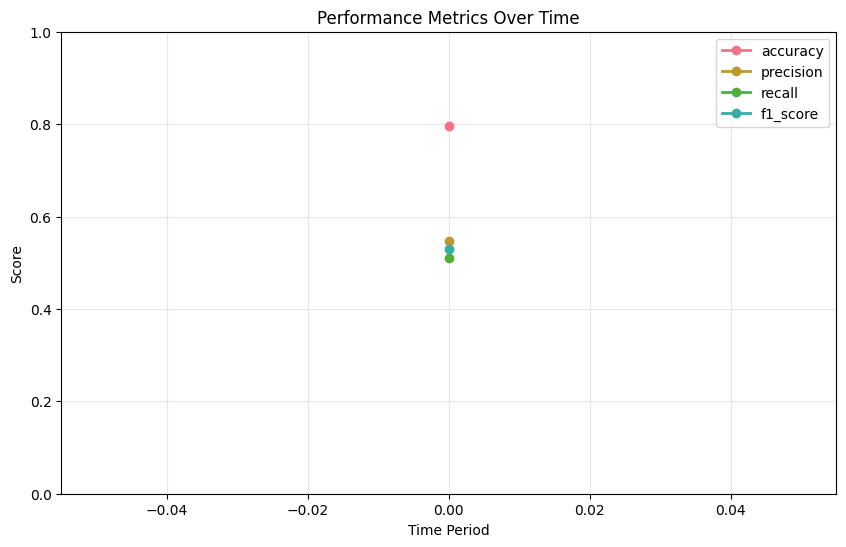

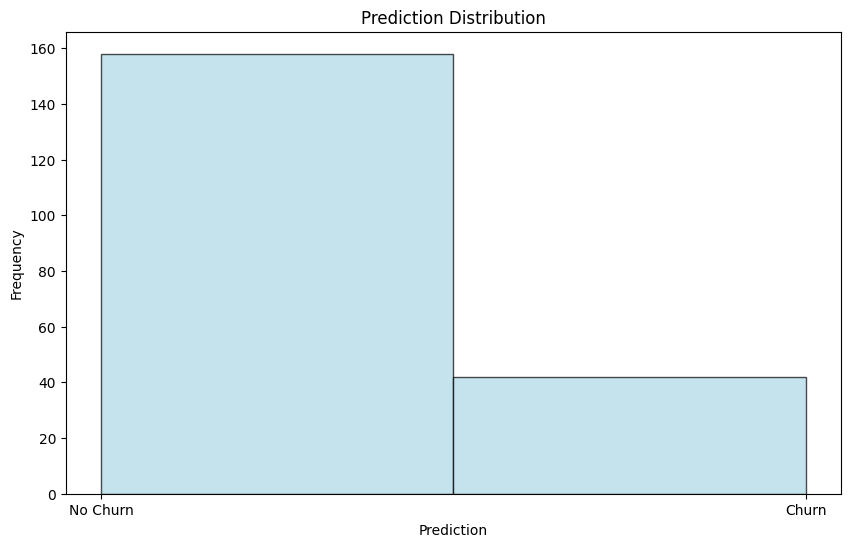

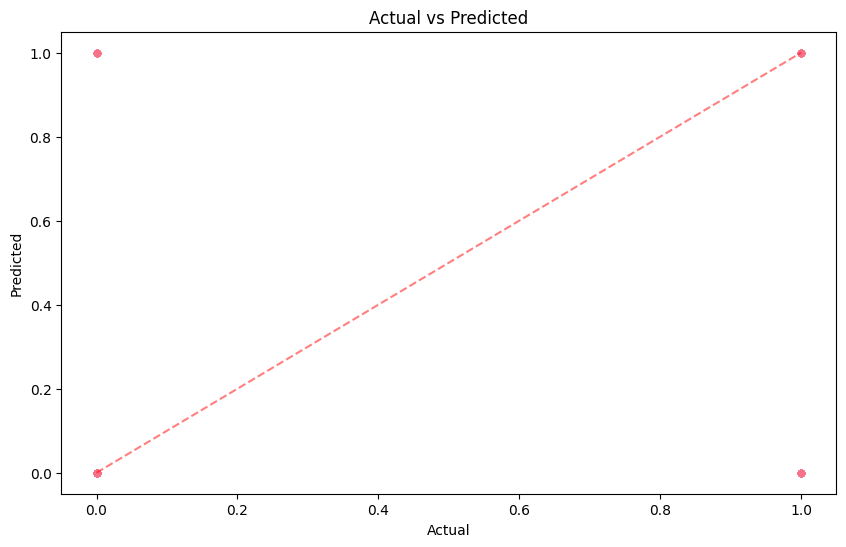

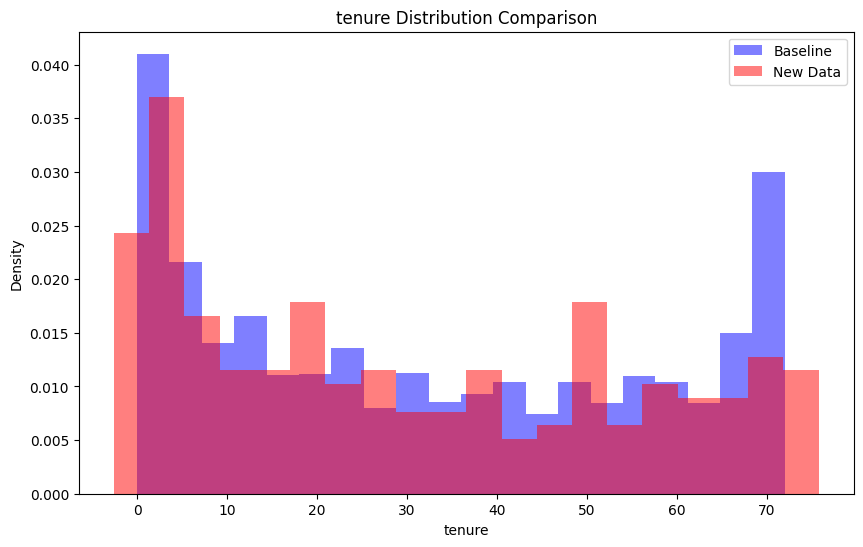

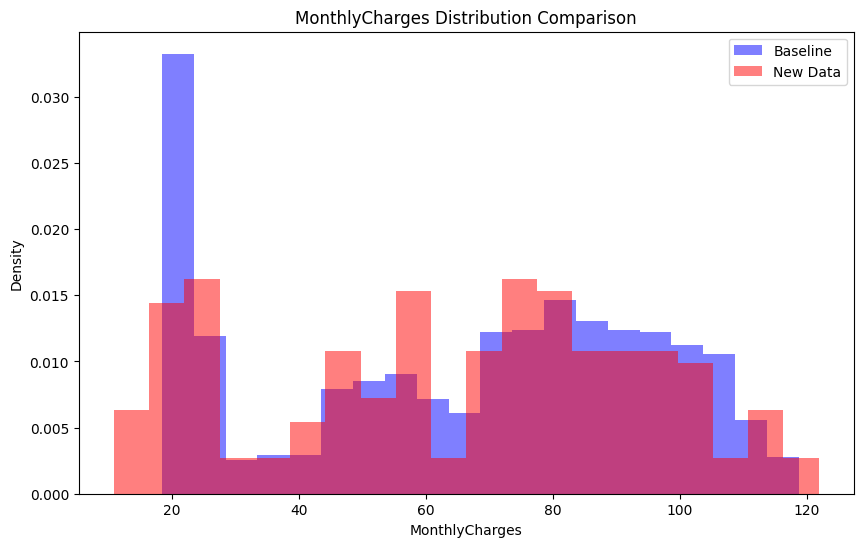

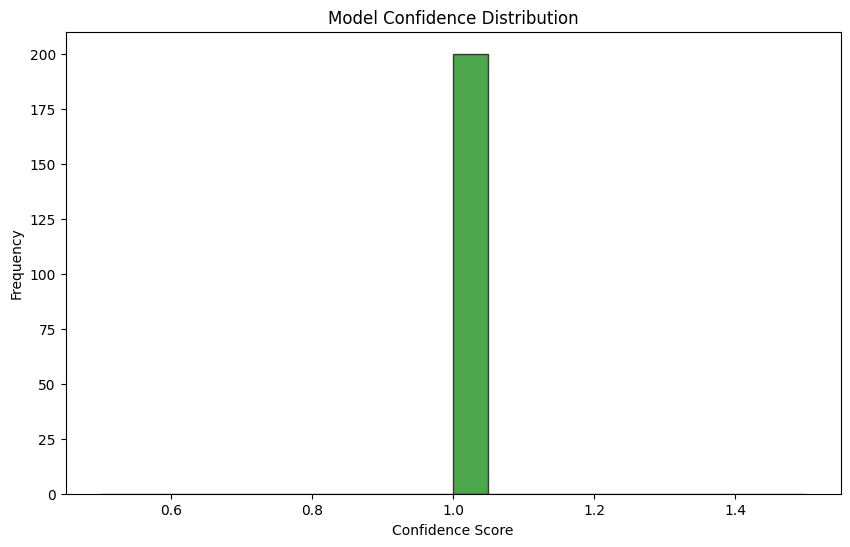


🔍 Data Drift Analysis:
Feature Drift Scores (higher = more drift):
  TotalCharges: 0.069 ✅ LOW
  Partner: 0.079 ✅ LOW
  tenure: 0.108 ✅ LOW
  Dependents: 0.050 ✅ LOW
  MonthlyCharges: 0.016 ✅ LOW
  SeniorCitizen: 0.063 ✅ LOW

📈 Performance Summary:
Latest Performance Metrics:
  accuracy: 0.795
  precision: 0.548
  recall: 0.511
  f1_score: 0.529


In [46]:
# Visualize monitoring data - Performance metrics over time
plt.figure(figsize=(10, 6))
if len(monitor.performance_history) > 0:
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    x = range(len(monitor.performance_history))
    
    for metric in metrics:
        values = [entry[metric] for entry in monitor.performance_history]
        plt.plot(x, values, marker='o', label=metric, linewidth=2)
    
    plt.xlabel('Time Period')
    plt.ylabel('Score')
    plt.title('Performance Metrics Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
plt.show()

# Prediction distribution
plt.figure(figsize=(10, 6))
predictions = [entry['prediction'] for entry in monitor.monitoring_data]
plt.hist(predictions, bins=2, alpha=0.7, color='lightblue', edgecolor='black')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10, 6))
actuals = [entry['actual'] for entry in monitor.monitoring_data]
plt.scatter(actuals, predictions, alpha=0.6, s=20)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
plt.show()

# Feature distribution comparison - Tenure
plt.figure(figsize=(10, 6))
feature = 'tenure'
baseline_values = [entry[feature] for entry in baseline_data]
new_values = [entry['input_data'][feature] for entry in monitor.monitoring_data]

plt.hist(baseline_values, bins=20, alpha=0.5, label='Baseline', color='blue', density=True)
plt.hist(new_values, bins=20, alpha=0.5, label='New Data', color='red', density=True)
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(f'{feature} Distribution Comparison')
plt.legend()
plt.show()

# Monthly charges distribution
plt.figure(figsize=(10, 6))
feature = 'MonthlyCharges'
baseline_values = [entry[feature] for entry in baseline_data]
new_values = [entry['input_data'][feature] for entry in monitor.monitoring_data]

plt.hist(baseline_values, bins=20, alpha=0.5, label='Baseline', color='blue', density=True)
plt.hist(new_values, bins=20, alpha=0.5, label='New Data', color='red', density=True)
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(f'{feature} Distribution Comparison')
plt.legend()
plt.show()

# Model confidence distribution
plt.figure(figsize=(10, 6))
confidences = []
for entry in monitor.monitoring_data:
    # Calculate confidence (distance from 0.5)
    prob = entry['prediction']
    confidence = abs(prob - 0.5) * 2  # Scale to 0-1
    confidences.append(confidence)

plt.hist(confidences, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Model Confidence Distribution')
plt.show()

# Data drift analysis
print(f"\n🔍 Data Drift Analysis:")
print("=" * 25)

# Calculate drift for the monitoring data
monitoring_data_list = [entry['input_data'] for entry in monitor.monitoring_data]
drift_scores = monitor.calculate_data_drift(monitoring_data_list)

if drift_scores:
    print("Feature Drift Scores (higher = more drift):")
    for feature, score in drift_scores.items():
        status = "⚠️  HIGH" if score > 0.5 else "✅ LOW"
        print(f"  {feature}: {score:.3f} {status}")
else:
    print("❌ Could not calculate drift scores")

# Performance summary
print(f"\n📈 Performance Summary:")
print("=" * 20)
if len(monitor.performance_history) > 0:
    latest_performance = monitor.performance_history[-1]
    print(f"Latest Performance Metrics:")
    for metric, value in latest_performance.items():
        if metric != 'timestamp':
            print(f"  {metric}: {value:.3f}")
else:
    print("No performance data available")


### Model Monitoring Summary

**Key Monitoring Capabilities:**

**Performance Tracking:**
- **Real-time metrics** - accuracy, precision, recall, F1 score
- **Performance degradation detection** - alerts when performance drops
- **Historical tracking** - monitor performance over time
- **Automated reporting** - comprehensive monitoring reports

**Data Drift Detection:**
- **Feature distribution comparison** - baseline vs new data
- **Statistical drift scores** - quantify distribution changes
- **Early warning system** - detect data quality issues
- **Visual monitoring** - charts and graphs for analysis

**Production Insights:**
- **Prediction logging** - track all model predictions
- **Confidence analysis** - monitor model certainty
- **Error tracking** - identify prediction failures
- **Business impact** - connect technical metrics to business outcomes

**Operational Benefits:**
- **Proactive monitoring** - detect issues before they impact business
- **Automated alerts** - notify teams of performance degradation
- **Data quality assurance** - ensure input data consistency
- **Model lifecycle management** - track model health over time


## Section 4: A/B Testing and Model Comparison

In production, you often need to compare different model versions or strategies to ensure you're using the best approach.


In [47]:
# A/B Testing and Model Comparison
print("🧪 A/B Testing and Model Comparison:")
print("=" * 40)

# Import required metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ABTestFramework:
    """
    A/B testing framework for model comparison
    """
    
    def __init__(self):
        self.test_groups = {}
        self.results = {}
        
    def create_test_groups(self, data, group_sizes=[0.5, 0.5], group_names=['A', 'B']):
        """Split data into test groups"""
        np.random.seed(42)
        n_samples = len(data)
        
        # Calculate group sizes
        group_counts = [int(n_samples * size) for size in group_sizes]
        group_counts[-1] = n_samples - sum(group_counts[:-1])  # Ensure all samples are assigned
        
        # Randomly assign samples to groups
        indices = np.random.permutation(n_samples)
        start_idx = 0
        
        for i, (group_name, count) in enumerate(zip(group_names, group_counts)):
            end_idx = start_idx + count
            group_indices = indices[start_idx:end_idx]
            self.test_groups[group_name] = group_indices
            start_idx = end_idx
            
        print(f"✅ Created test groups:")
        for group_name, indices in self.test_groups.items():
            print(f"  Group {group_name}: {len(indices)} samples")
    
    def run_model_comparison(self, data, model_a, model_b, actuals):
        """Run A/B test comparing two models"""
        results = {}
        
        for group_name, indices in self.test_groups.items():
            group_data = data.iloc[indices]
            group_actuals = actuals.iloc[indices]
            
            # Choose model based on group
            if group_name == 'A':
                model = model_a
            else:
                model = model_b
            
            # Make predictions
            predictions = model.predict(group_data)
            probabilities = model.predict_proba(group_data)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(group_actuals, predictions)
            precision = precision_score(group_actuals, predictions)
            recall = recall_score(group_actuals, predictions)
            f1 = f1_score(group_actuals, predictions)
            
            results[group_name] = {
                'model': 'Model A' if group_name == 'A' else 'Model B',
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'sample_size': len(indices),
                'predictions': predictions,
                'probabilities': probabilities,
                'actuals': group_actuals.values
            }
        
        self.results = results
        return results
    
    def statistical_significance_test(self, metric='accuracy', alpha=0.05):
        """Test for statistical significance between groups"""
        from scipy import stats
        
        group_a_metrics = self.results['A'][metric]
        group_b_metrics = self.results['B'][metric]
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group_a_metrics, group_b_metrics)
        
        is_significant = p_value < alpha
        
        return {
            'metric': metric,
            't_statistic': t_stat,
            'p_value': p_value,
            'is_significant': is_significant,
            'alpha': alpha
        }
    
    def generate_ab_test_report(self):
        """Generate comprehensive A/B test report"""
        report = {
            'test_summary': {},
            'performance_comparison': {},
            'statistical_tests': {},
            'recommendations': []
        }
        
        # Performance comparison
        for group_name, results in self.results.items():
            report['performance_comparison'][group_name] = {
                'accuracy': results['accuracy'],
                'precision': results['precision'],
                'recall': results['recall'],
                'f1_score': results['f1_score'],
                'sample_size': results['sample_size']
            }
        
        # Statistical significance tests
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        for metric in metrics:
            test_result = self.statistical_significance_test(metric)
            report['statistical_tests'][metric] = test_result
        
        # Recommendations
        accuracy_a = self.results['A']['accuracy']
        accuracy_b = self.results['B']['accuracy']
        
        if accuracy_a > accuracy_b:
            report['recommendations'].append(f"Model A performs better on accuracy ({accuracy_a:.3f} vs {accuracy_b:.3f})")
        else:
            report['recommendations'].append(f"Model B performs better on accuracy ({accuracy_b:.3f} vs {accuracy_a:.3f})")
        
        return report

# Create a second model for comparison (with different hyperparameters)
model_b = LogisticRegression(random_state=42, max_iter=1000, C=0.1)  # Different regularization
model_b.fit(X_train_scaled, y_train)

print("✅ Created second model for A/B testing")

# Initialize A/B test framework
ab_test = ABTestFramework()

# Create test groups
ab_test.create_test_groups(X_test_scaled, group_sizes=[0.5, 0.5], group_names=['A', 'B'])

# Run model comparison
comparison_results = ab_test.run_model_comparison(
    pd.DataFrame(X_test_scaled), 
    model, 
    model_b, 
    y_test
)

print(f"\n📊 A/B Test Results:")
print("=" * 20)
for group_name, results in comparison_results.items():
    print(f"\nGroup {group_name} ({results['model']}):")
    print(f"  Accuracy: {results['accuracy']:.3f}")
    print(f"  Precision: {results['precision']:.3f}")
    print(f"  Recall: {results['recall']:.3f}")
    print(f"  F1 Score: {results['f1_score']:.3f}")
    print(f"  Sample Size: {results['sample_size']}")

# Generate comprehensive report
report = ab_test.generate_ab_test_report()

print(f"\n📋 A/B Test Report:")
print("=" * 20)
print("Performance Comparison:")
for group_name, metrics in report['performance_comparison'].items():
    print(f"  Group {group_name}: Accuracy = {metrics['accuracy']:.3f}")

print("\nStatistical Significance Tests:")
for metric, test_result in report['statistical_tests'].items():
    significance = "Significant" if test_result['is_significant'] else "Not Significant"
    print(f"  {metric}: p-value = {test_result['p_value']:.4f} ({significance})")

print("\nRecommendations:")
for recommendation in report['recommendations']:
    print(f"  • {recommendation}")


🧪 A/B Testing and Model Comparison:
✅ Created second model for A/B testing
✅ Created test groups:
  Group A: 704 samples
  Group B: 705 samples

📊 A/B Test Results:

Group A (Model A):
  Accuracy: 0.777
  Precision: 0.623
  Recall: 0.429
  F1 Score: 0.508
  Sample Size: 704

Group B (Model B):
  Accuracy: 0.783
  Precision: 0.621
  Recall: 0.443
  F1 Score: 0.517
  Sample Size: 705

📋 A/B Test Report:
Performance Comparison:
  Group A: Accuracy = 0.777
  Group B: Accuracy = 0.783

Statistical Significance Tests:
  accuracy: p-value = nan (Not Significant)
  precision: p-value = nan (Not Significant)
  recall: p-value = nan (Not Significant)
  f1_score: p-value = nan (Not Significant)

Recommendations:
  • Model B performs better on accuracy (0.783 vs 0.777)


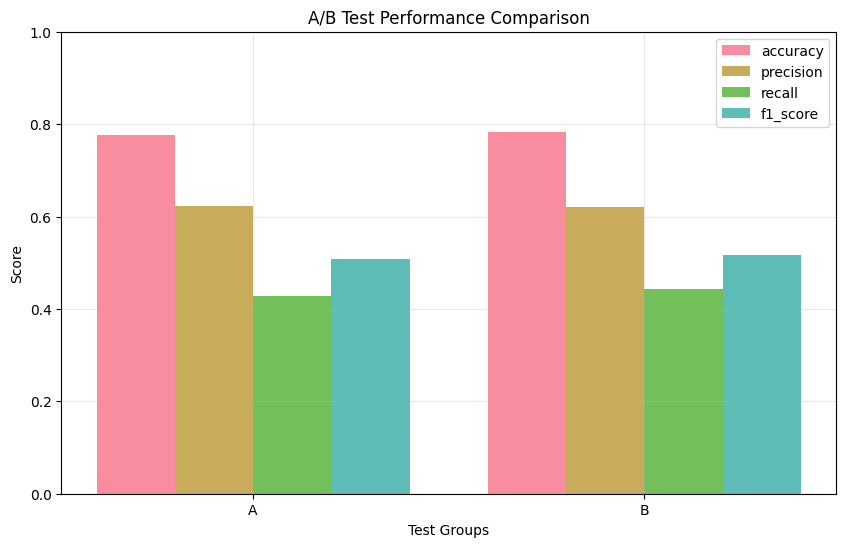

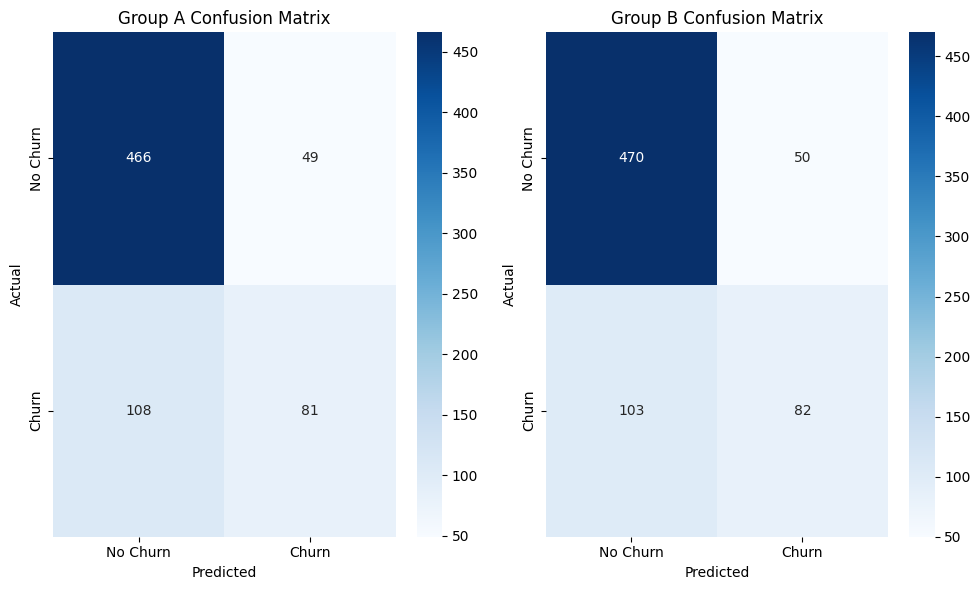

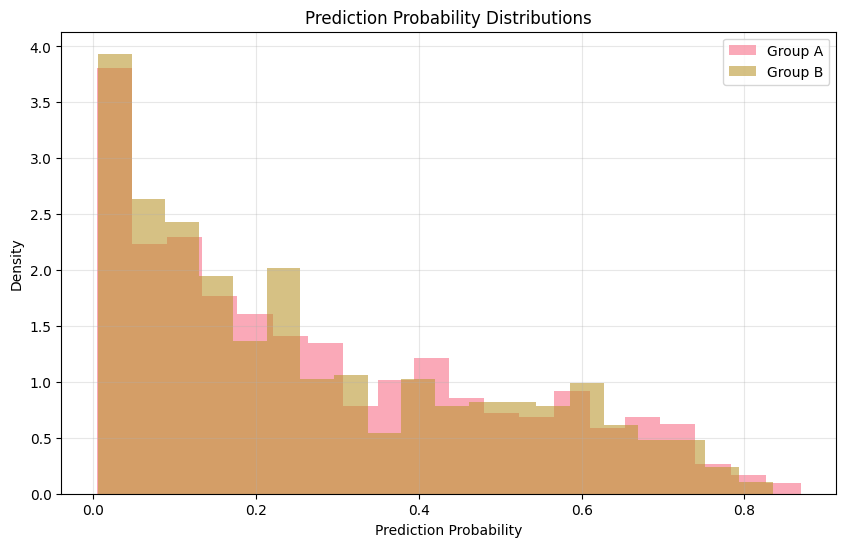

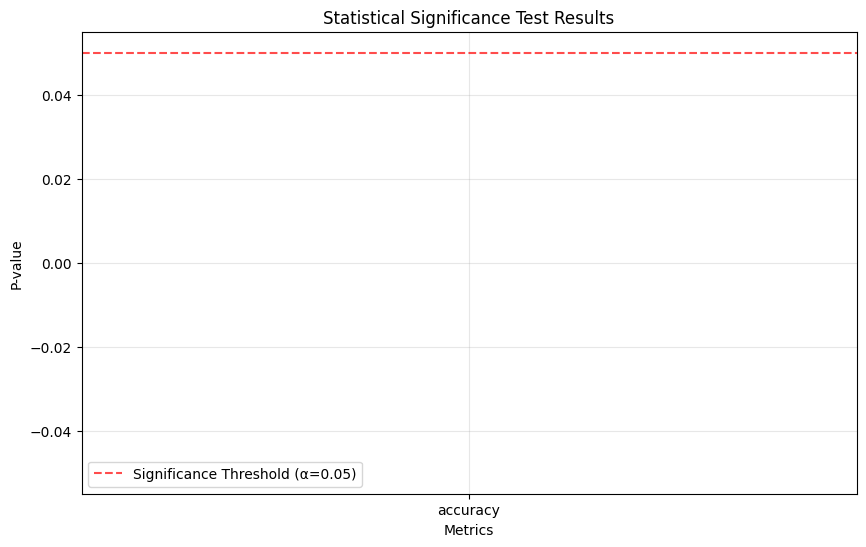

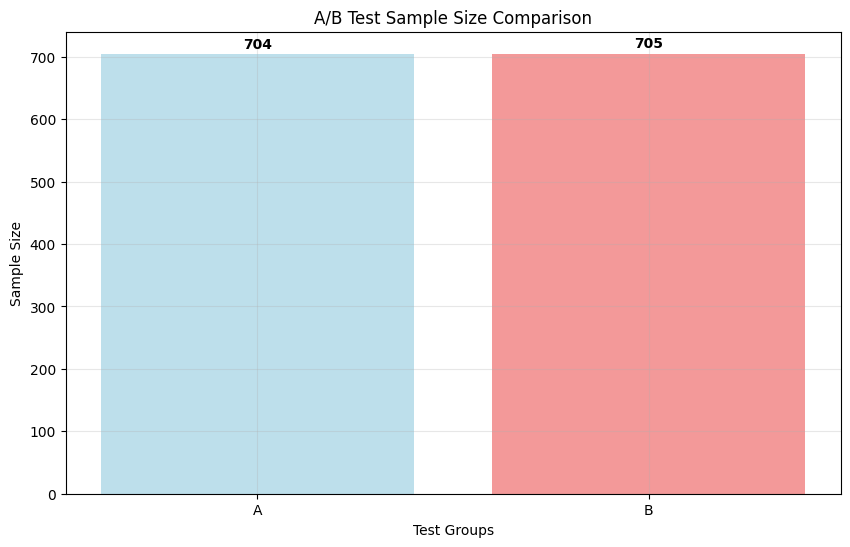


📊 A/B Test Performance Summary:

Group A (Model A):
  Accuracy: 0.777
  Precision: 0.623
  Recall: 0.429
  F1 Score: 0.508
  Sample Size: 704

Group B (Model B):
  Accuracy: 0.783
  Precision: 0.621
  Recall: 0.443
  F1 Score: 0.517
  Sample Size: 705

📈 Statistical Significance Results:
accuracy: p-value = nan ❌ NOT SIGNIFICANT
precision: p-value = nan ❌ NOT SIGNIFICANT
recall: p-value = nan ❌ NOT SIGNIFICANT
f1_score: p-value = nan ❌ NOT SIGNIFICANT


In [48]:
# Visualize A/B test results - Performance comparison
plt.figure(figsize=(10, 6))
groups = list(comparison_results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(groups))
width = 0.2

for i, metric in enumerate(metrics):
    values = [comparison_results[group][metric] for group in groups]
    plt.bar(x + i*width, values, width, label=metric, alpha=0.8)

plt.xlabel('Test Groups')
plt.ylabel('Score')
plt.title('A/B Test Performance Comparison')
plt.xticks(x + width*1.5, groups)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

# Confusion matrices comparison
plt.figure(figsize=(10, 6))
for i, (group_name, results) in enumerate(comparison_results.items()):
    plt.subplot(1, 2, i+1)
    cm = confusion_matrix(results['actuals'], results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Group {group_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Prediction probability distributions
plt.figure(figsize=(10, 6))
for group_name, results in comparison_results.items():
    plt.hist(results['probabilities'], bins=20, alpha=0.6, 
             label=f'Group {group_name}', density=True)
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.title('Prediction Probability Distributions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Statistical significance results
plt.figure(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
p_values = []
is_significant = []

for metric in metrics:
    test_result = ab_test.statistical_significance_test(metric)
    p_values.append(test_result['p_value'])
    is_significant.append(test_result['is_significant'])

colors = ['red' if sig else 'green' for sig in is_significant]
bars = plt.bar(metrics, p_values, color=colors, alpha=0.7)
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Significance Threshold (α=0.05)')
plt.xlabel('Metrics')
plt.ylabel('P-value')
plt.title('Statistical Significance Test Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Add significance labels
for i, (bar, sig) in enumerate(zip(bars, is_significant)):
    height = bar.get_height()
    label = 'Significant' if sig else 'Not Significant'
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             label, ha='center', va='bottom', fontweight='bold')
plt.show()

# Sample size comparison
plt.figure(figsize=(10, 6))
groups = list(comparison_results.keys())
sample_sizes = [comparison_results[group]['sample_size'] for group in groups]
plt.bar(groups, sample_sizes, color=['lightblue', 'lightcoral'], alpha=0.8)
plt.xlabel('Test Groups')
plt.ylabel('Sample Size')
plt.title('A/B Test Sample Size Comparison')
plt.grid(True, alpha=0.3)

# Add sample size labels on bars
for i, size in enumerate(sample_sizes):
    plt.text(i, size + 5, str(size), ha='center', va='bottom', fontweight='bold')
plt.show()

# Performance metrics summary
print(f"\n📊 A/B Test Performance Summary:")
print("=" * 35)
for group_name, results in comparison_results.items():
    print(f"\nGroup {group_name} ({results['model']}):")
    print(f"  Accuracy: {results['accuracy']:.3f}")
    print(f"  Precision: {results['precision']:.3f}")
    print(f"  Recall: {results['recall']:.3f}")
    print(f"  F1 Score: {results['f1_score']:.3f}")
    print(f"  Sample Size: {results['sample_size']}")

# Statistical significance summary
print(f"\n📈 Statistical Significance Results:")
print("=" * 35)
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    test_result = ab_test.statistical_significance_test(metric)
    status = "✅ SIGNIFICANT" if test_result['is_significant'] else "❌ NOT SIGNIFICANT"
    print(f"{metric}: p-value = {test_result['p_value']:.4f} {status}")


### A/B Testing Summary

**Key A/B Testing Features:**

**Experimental Design:**
- **Random group assignment** - ensures unbiased comparison
- **Balanced sample sizes** - equal representation in each group
- **Controlled variables** - only model differences vary between groups
- **Statistical rigor** - proper experimental methodology

**Performance Comparison:**
- **Multiple metrics** - accuracy, precision, recall, F1 score
- **Statistical significance** - t-tests to determine if differences are real
- **Visual analysis** - comprehensive charts and graphs
- **Confusion matrices** - detailed error analysis

**Production Benefits:**
- **Data-driven decisions** - choose best model based on evidence
- **Risk mitigation** - test new models before full deployment
- **Performance optimization** - continuously improve model performance
- **Business validation** - ensure model changes improve business outcomes

**Operational Value:**
- **Confidence in changes** - statistical validation of improvements
- **Rollback capability** - easy to revert if new model performs worse
- **Continuous improvement** - systematic approach to model enhancement
- **Stakeholder communication** - clear evidence for model decisions


## Summary: Model Deployment and Production Considerations

This notebook demonstrated the complete journey from model development to production deployment:

### What We Accomplished

1. **Model Persistence:** Properly saved and versioned model components for production use

2. **Prediction Pipeline:** Created a robust, production-ready prediction system with error handling

3. **Model Monitoring:** Implemented comprehensive monitoring for performance tracking and data drift detection

4. **A/B Testing:** Built a framework for comparing different model versions with statistical rigor

### Key Takeaways

- **Model persistence** is crucial for reproducible deployments
- **Robust pipelines** handle real-world data variations and errors
- **Continuous monitoring** detects performance degradation and data drift
- **A/B testing** provides data-driven evidence for model decisions
- **Production systems** require different considerations than development
- **Statistical rigor** ensures reliable model comparisons
- **Business integration** transforms technical models into business value
